In [17]:
# System modules
import pickle
import folium
from folium import plugins
import numpy as np
import pandas as pd
from time import time
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

# User modules
from domain.base import DataRequest
import domain.fs_engine as netatmo
from domain.elevation_service import (
    ElevationServiceConnector
)

from helpers.utils import (
    get_station_coordinates,
    add_station_elevations,
    select_near,
    add_alias
)
import helpers.knmi_obs_ingest as knmi


In [2]:
# Read station meta data
with open('data/stations.csv', 'r') as f:
    station_meta_data = pd.read_csv(f)
print("Loaded meta data for %d stations." % len(station_meta_data))

Loaded meta data for 13254 stations.


In [3]:
# Defining a request for the Netherlands
request = DataRequest()
start_dt = datetime(2016, 3, 25, 0, 0)
# end_dt = datetime(2016, 3, 25, 6, 0)
end_dt = datetime(2016, 4, 13, 15, 0)
request.start_datetime = start_dt
request.end_datetime = end_dt
request.time_resolution = 10
request.region = (53.680, 2.865, 50.740, 7.323)
print("Request defined from %s to %s" % (start_dt, end_dt))

Request defined from 2016-03-25 00:00:00 to 2016-04-13 15:00:00


In [ ]:
# Load KNMI 10-minute observations from disk.
print("Querying KNMI observation data..")
knmi_path = 'X:/netatmo/obs/'
knmi_fsengine = knmi.FileSystemEngine(knmi_path)
obs_data = knmi_fsengine.query(request)

In [ ]:
# Dump observation data to a single file for caching.
with open('data/netherlands_obs_3-25_4-15.pkl', 'wb') as f:
    pickle.dump(obs_data, f)

In [4]:
# Load cached observations.
load_start = time()
with open('data/netherlands_obs_3-25_4-15.pkl', 'rb') as f:
    obs_data = pickle.load(f)
print("Done loading observations (%fs)." % (time() - load_start))

Done loading observations (87.071098s).


In [5]:
# TODO Remove me on new pickled obs file
obs_data.sort_values('valid_datetime', axis=0, inplace=True)

In [ ]:
# Query netatmo data from disk.
netatmo_path = 'X:/netatmo/data/'
print("Querying NetAtmo file system engine..")
netatmo_fsengine = netatmo.FileSystemEngine(netatmo_path)
response = netatmo_fsengine.query(request)
data_map = response.data_map
print("%d stations loaded." % len(data_map))

In [ ]:
# Dump NetAtmo data to a single file for caching.
with open('data/netherlands_3-25_4-15.pkl', 'wb') as f:
    pickle.dump(data_map, f)

In [6]:
# Load cached NetAtmo data.
load_start = time()
with open("data/netherlands_3-25_4-15.pkl", "rb") as f:
    data_map = pickle.load(f)
print("Done loading NetAtmo data (%fs)." % (time() - load_start))

Done loading NetAtmo data (141.335773s).


In [7]:
# # TODO Remove me when pickled object is updated.
# def add_alias(data_map):
#     """Add an alias station_id to every Station object."""
#     # TODO TdR 28-4-2016 Closeby stations should have closeby aliases.
#     alias_id = 1
#     for station_id in data_map:
#         station = data_map[station_id]
#         station.alias = alias_id
#         alias_id += 1

add_alias(data_map)

In [106]:
# Select stations at or near a specified station id
query_station_id = 6260  # WMO station to search nearby
radius = 5000  # Search radius in meters

# Do search and interpolation
query_station_location = station_meta_data.loc[station_meta_data.stationId == query_station_id, ["latitude", "longitude"]]
print("Query station location: lat %f, lon %f" % (query_station_location.latitude, query_station_location.longitude))

near_station_map = select_near(
                                data_map, 
                                query_station_location.latitude, query_station_location.longitude,
                                radius=radius
                              )

print("%d stations near WMO station %d." % (len(near_station_map), query_station_id))
netatmo.resample_and_interpolate(near_station_map, request.time_resolution)
print("Done.")

Query station location: lat 52.098888, lon 5.179717
217 stations near WMO station 6260.
1 / 217 stations processed..
217 / 217 stations processed..
Done.


In [107]:
# Construct a map plot of the query station and its found nearby NetAtmo stations.
query_lat = list(query_station_location.latitude.values)
query_lon = list(query_station_location.longitude.values)
map_1 = folium.Map(
    query_lat + query_lon,
    zoom_start=13, 
    tiles='stamentoner'
)
# Draw point of interest
folium.Marker(query_lat + query_lon, icon=folium.Icon(color='red')).add_to(map_1)

# Draw search radius
folium.CircleMarker(
    query_lat + query_lon,
    radius=radius,
    color='#3186cc',
    fill_color='#C7DDF0',
   ).add_to(map_1)

for station_id in near_station_map:
    station = near_station_map[station_id]
    folium.Marker([station.latitude, station.longitude], popup="Station id: N%d" % station.alias).add_to(map_1)
map_1

Station 6260 has 2830 observations for element humidity
0 stations are installed inside and are discarded.
MAE Merged NetAtmo vs. WMO: 5.267753
RMSE Merged NetAtmo vs. WMO: 6.626969
213 stations were merged.


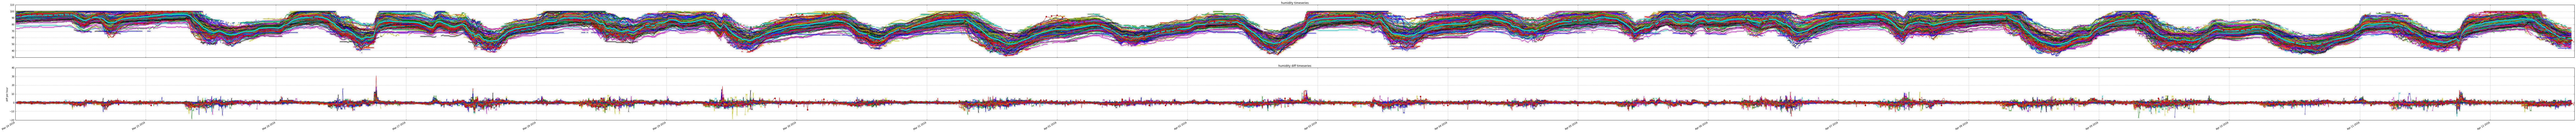

In [113]:
# Plotting of timeseries of nearby NetAtmo stations.
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, figsize=(200, 10), sharex=True)
ax1.set_xlabel("Valid datetime")

element = 'humidity'
show_radiation = False
show_grass = False
show_merged = True
show_individual = True

# Construct observation series
gp = obs_data.groupby('station_id')
wmo_obs = gp.get_group(query_station_id)
if element == 'pressure':
    knmi_name = 'p0'
elif element == 'temperature':
    knmi_name = 'ta'
elif element == 'humidity':
    knmi_name = 'rh'
wmo_obs_el = wmo_obs[wmo_obs.element_name==knmi_name]

print("Station %d has %d observations for element %s" % (query_station_id, len(wmo_obs_el), element))

# == Data processing ==
merged_data = None  # Container for mean data
for station_id in near_station_map:
    station = near_station_map[station_id].thermo_module
    station_alias = 'Station %d' % near_station_map[station_id].alias
    if element in station:
        if merged_data is None:
            merged_data = station[[element]].add_suffix("_N%d" % near_station_map[station_id].alias)
        else:
            merged_data = merged_data.join(station[[element]].add_suffix("_N%d" % near_station_map[station_id].alias),
                                           how='outer')

# Compute features for quality check
val_range = (merged_data.max(axis=0) - merged_data.min(axis=0))
val_sd = merged_data.std(axis=0)
val_mean = merged_data.mean(axis=0)

# Merge features
station_features = pd.concat([val_range, val_sd, val_mean], axis=1)
station_features.columns = ['range', 'sd', 'mean']

# The 'is_inside' check currently only works for temperature.
if element =='temperature':
    station_features['is_inside'] = np.logical_and(station_features.sd < 2, station_features.range < 10)
else:
    station_features['is_inside'] = False

# Select good stations
print("%d stations are installed inside and are discarded." % station_features.is_inside.sum())
outside_station_names = list(station_features[~station_features.is_inside].index)
merged_data = merged_data[outside_station_names]

# == Two-tailed Z-test on every date ==
alpha = 0.04
# Calculate mean per row
mean_per_date = merged_data.mean(axis=1)
std_per_date = merged_data.std(axis=1)
# Calculate CDF per row
merged_cdf_vals = merged_data.apply(
    norm.cdf,
    axis=0,
    loc=mean_per_date,
    scale=std_per_date
)
# Filter out values above threshold
merged_data = merged_data.mask(
    merged_cdf_vals.applymap(lambda x: (x > 1 - (0.5 * alpha)) or (x < (0.5 * alpha)))
)

# == Compute root mean squared error ==
obs_copy = wmo_obs_el.copy()
obs_copy.set_index('valid_datetime', inplace=True)
wmo_netatmo = merged_data.mean(axis=1).to_frame(name='netatmo_' + element).join(obs_copy, how='outer')
wmo_netatmo.rename(
    columns={
        'value': 'wmo_' + element
    },
    inplace=True
)
wmo_netatmo.drop(['element_name', 'station_id'], axis=1, inplace=True)
error = wmo_netatmo['netatmo_' + element] - wmo_netatmo['wmo_' + element]
mae = error.abs().mean()
rmse = np.sqrt(error.apply(np.square).mean())
print("MAE Merged NetAtmo vs. WMO: %f" % mae)
print("RMSE Merged NetAtmo vs. WMO: %f" % rmse)

# == First subplot == 
if show_individual:
    for name in merged_data:    
        p = ax1.plot(merged_data.index.values, merged_data[name].values, marker='x', label=name)
            
# Plot mean temperature of stations
if show_merged:
    ax1.plot(merged_data.index.values, merged_data.mean(axis=1), label='NetAtmo Mean', linewidth=2, color='cyan', marker='o')
    ax1.fill_between(
        merged_data.index.values, 
        merged_data.mean(axis=1) - merged_data.std(axis=1),
        merged_data.mean(axis=1) + merged_data.std(axis=1),
        color='cyan'
    )
    
nr_merged_stations = 0 if merged_data is None else len(merged_data.columns)
print("%d stations were merged." % nr_merged_stations)
        
# Plot element observations
ax1.plot(wmo_obs_el['valid_datetime'].values, wmo_obs_el['value'].values, color='red', marker='o', markevery=6, label='WMO T')

# Plot radiation observations
if show_radiation:
    wmo_obs_qg = wmo_obs[wmo_obs.element_name=='qg']
    ax12 = ax1.twinx()
    ax12.plot(wmo_obs_qg['valid_datetime'].values, wmo_obs_qg['value'].values, color='green', marker='o', markevery=6, label='WMO QG')
    ax12.set_ylabel("Incoming radiation")
    
if show_grass:
    wmo_obs_qg = wmo_obs[wmo_obs.element_name=='tgn']
    ax1.plot(wmo_obs_qg['valid_datetime'].values, wmo_obs_qg['value'].values, color='blue', marker='o', markevery=6, label='WMO TGN')
    
# == Second subplot ==
# Take difference over rows
merged_data_diff = merged_data.diff(axis=0)
# Plot station diffs
if show_individual:
    for name in merged_data:
        ax2.plot(merged_data_diff.index.values, merged_data_diff[name].values, marker='x', label=name)
# Plot WMO diff
ax2.plot(wmo_obs_el['valid_datetime'].values, wmo_obs_el['value'].diff().values, color='red', marker='o', markevery=6, label='WMO T')

# Plot cleanup
fig.autofmt_xdate()
plt.xticks(wmo_obs_el['valid_datetime'].values[0::144])  # Make ticks daily
plt.xlim([min(wmo_obs_el['valid_datetime'].values), max(wmo_obs_el['valid_datetime'].values)])
ax1.set_title("%s timeseries" % element)
ax2.set_title("%s diff timeseries" % element)
ax2.set_ylabel("diff per hour")
ax1.grid('on')
ax2.grid('on')
# ax1.legend(numpoints=1)
# ax2.legend(numpoints=1)
plt.show()
